In [317]:
import numpy as np

In [318]:
def rbm_phi(s, a, b, W):
    c = np.dot(a, s)
    d = 1
    for i in range(len(b)):
        d *= 2 * np.cosh(b[i] + np.dot(W[i], s))
        

    return np.exp(c) * d


def rbm_phi_flat(s, a, b, W):
    W = np.reshape(W, (len(b), len(s)))
    return rbm_phi(s, a, b, W)

In [319]:
def o_der_a(s, a, b, W):
    return s

In [320]:
def o_der_b(s, a, b, W):
    return np.array([np.tanh(b[i] + np.dot(W[i], s)) for i in range(len(b))])

In [321]:
def o_der_W(s, a, b, W):
    return np.array([[s[k] * np.tanh(b[i] + np.dot(W[i], s)) for k in range(len(W[0]))] for i in range(len(W))])


In [322]:
# Let's text the derivative functions by comparing them to finite difference approximations.

def finite_diff(f, x, i, h):
    return (f(x + h * np.eye(len(x))[i]) - f(x - h * np.eye(len(x))[i])) / (2 * h)

def finite_diff_grad(f, x, h):
    return np.array([finite_diff(f, x, i, h) for i in range(len(x))])

def test_derivatives():
    a = np.array([0.1, 0.2])
    b = np.array([0.3, 0.4])
    W = np.array([[0.5, 0.6], [0.7, 0.8]])
    s = np.array([1, 0])


    print("RBM values:")
    print(rbm_phi(s, a, b, W))


    h = 1e-6
    print("Analytical derivatives:")
    print(o_der_a(s, a, b, W)*rbm_phi(s, a, b, W))
    print(o_der_b(s, a, b, W)*rbm_phi(s, a, b, W))
    print(o_der_W(s, a, b, W)*rbm_phi(s, a, b, W).flatten())

    print("Finite difference derivatives:")
    print(finite_diff_grad(lambda x: rbm_phi(s, x, b, W), a, h))
    print(finite_diff_grad(lambda x: rbm_phi(s, a, x, W), b, h))
    print(finite_diff_grad(lambda x: rbm_phi_flat(s, a, b, x), W.flatten(), h))



In [323]:
test_derivatives()

RBM values:
9.864910437871492
Analytical derivatives:
[9.86491044 0.        ]
[6.55066327 7.89685116]
[[6.55066327 0.        ]
 [7.89685116 0.        ]]
Finite difference derivatives:
[9.86491044 0.        ]
[6.55066327 7.89685115]
[6.55066327 0.         7.89685115 0.        ]


In [324]:
def rbm_phi_theta(s, theta):
    n = len(s)
    m = (len(theta) - n) // (n+1)
    a = theta[:n]
    b = theta[n:n+m]
    W = np.reshape(theta[n+m:], (m, n))
    return rbm_phi(s, a, b, W)

def o_der_theta(s, theta):
    n = len(s)
    m = (len(theta) - n) // (n+1)
    a = theta[:n]
    b = theta[n:n+m]
    W = np.reshape(theta[n+m:], (m, n))
    return np.concatenate([o_der_a(s, a, b, W), o_der_b(s, a, b, W), o_der_W(s, a, b, W).flatten()])

def grad_rbm_phi_theta(s, theta):
    return o_der_theta(s, theta) * rbm_phi_theta(s, theta)




In [325]:
def create_random_state(N):
    phi = np.random.rand(N)
    #normalize phi^2
    phi = phi / np.sqrt(np.dot(phi, phi))
    return phi



In [326]:
def loss(phi, theta):
    N = len(phi)
    l = 0
    magnitude = np.linalg.norm([rbm_phi_theta(np.eye(N)[j], theta) for j in range(N)])
    for i in range(N):
        si = np.eye(N)[i]
        l += np.square(phi[i] - rbm_phi_theta(si, theta)/magnitude)
    return l/2

In [327]:
def diff_loss(phi, theta):
    N = len(phi)
    magnitude = np.linalg.norm([rbm_phi_theta(np.eye(N)[j], theta) for j in range(N)])
    d = 0
    for i in range(N):
        si = np.eye(N)[i]
        d += (phi[i] - rbm_phi_theta(si, theta)/magnitude) * -(grad_rbm_phi_theta(si, theta)/magnitude - phi[i] * np.sum([grad_rbm_phi_theta(np.eye(N)[j], theta)*rbm_phi_theta(np.eye(N)[j], theta) for j in range(N)])/magnitude**3)
    return d

In [328]:
def gradient_descent(phi, M, learning_rate, max_iter):
    N = len(phi)
    theta = np.random.rand(N + M*(N+1))
    learned_theta = np.copy(theta)
    losses = []
    for _ in range(max_iter):
        learned_theta -= learning_rate * diff_loss(phi, learned_theta)
        losses.append(loss(phi, learned_theta))
    return theta, learned_theta, losses

In [329]:
# N, M = 3, 6
# 
# phi, random_a, random_b, random_W = create_random_state(N, M)
# random_theta = np.concatenate([random_a, random_b, random_W.flatten()])
# print(len(random_theta))
# print("Initial loss:", loss(phi, random_theta))
# print("Initial random theta:", random_theta)
# print("Initial random phi:", phi)
# print("Gradient descent:")
# new_theta, _ = gradient_descent(random_theta, phi, 0.001, 10000)
# print("Final loss:", loss(phi, new_theta))
# print("Final random theta:", random_theta)
# print("Final theta:", new_theta)


In [330]:
import matplotlib.pyplot as plt

def plot_phi_theta(phi, theta, label="phi_theta"):
    N = len(phi)
    x = np.linspace(0, N-1, N)
    magnitude = np.linalg.norm([rbm_phi_theta(np.eye(N)[j], theta) for j in range(N)])
    y = [rbm_phi_theta(np.eye(N)[i], theta)/magnitude for i in range(N)]
    plt.plot(x, y, label=label)
    y = [phi[i] for i in range(N)]
    plt.plot(x, y, label="phi")
    plt.legend()
    plt.show()


In [331]:
# plot_phi_theta(phi, random_theta, label = "Initial random theta")
# plot_phi_theta(phi, new_theta, label = "Final theta")



Final loss with M = 0: 0.006445558899983093


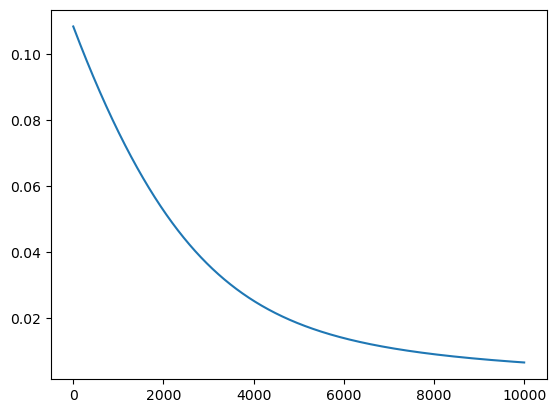

Final loss with M = 1: 0.004295622598490685


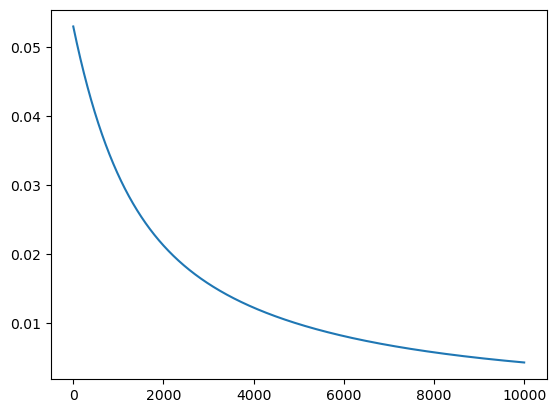

Final loss with M = 2: 0.0053803178712009975


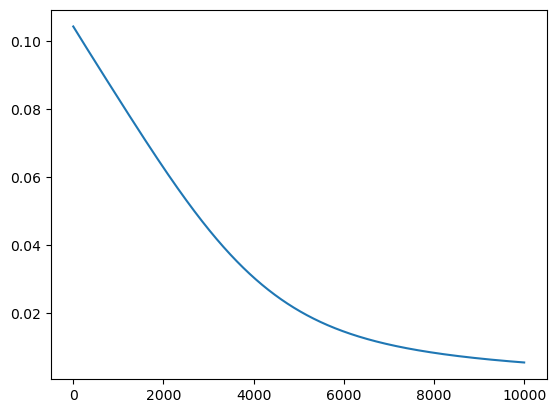

Final loss with M = 3: 0.0015061013144727039


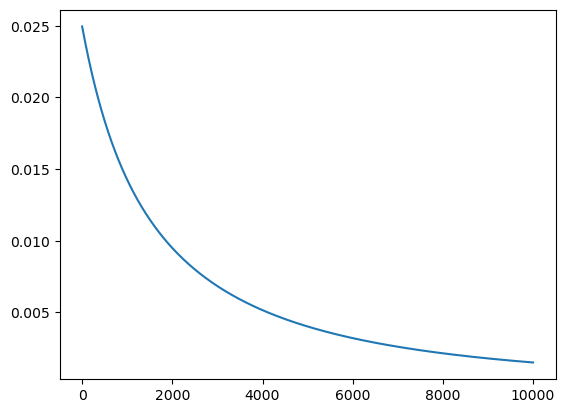

Final loss with M = 4: 0.00218935444775818


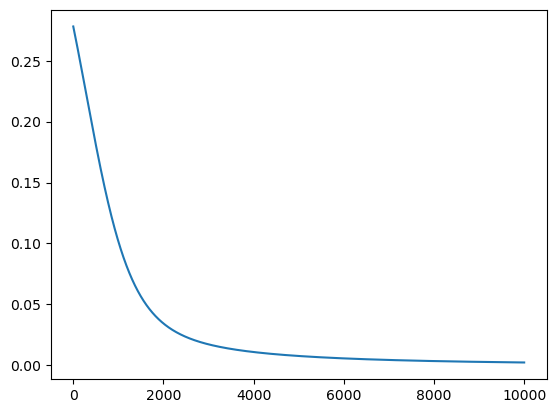

Final loss with M = 5: 0.0008949952333286005


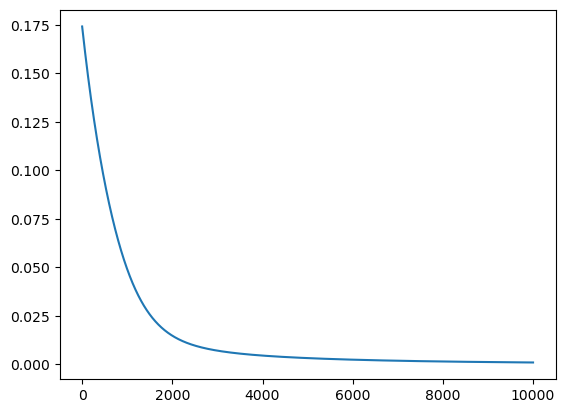

The ratio M/N needed to get a loss below 0.001 is 1.5


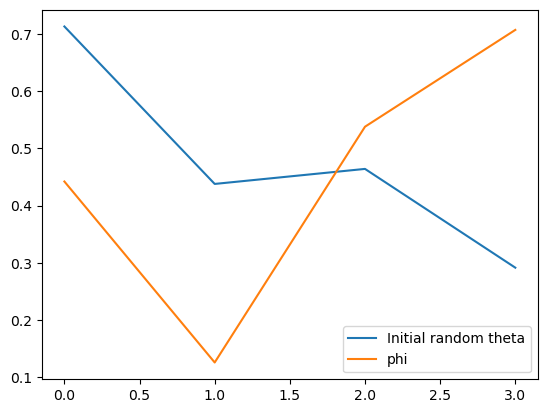

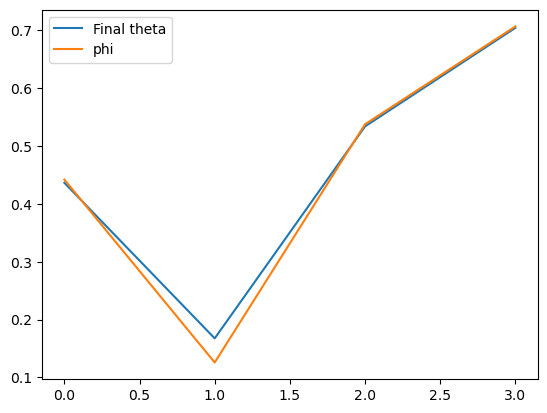

In [334]:
N, M = 4, 0
phi= create_random_state(N)
l = 1
while l > 0.001:
    random_theta, new_theta, losses = gradient_descent(phi, M, 0.001, 10000)
    l = loss(phi, new_theta)
    print(f"Final loss with M = {M}:", l)
    M += 1
    plt.plot(losses)
    plt.show()
print("The ratio M/N needed to get a loss below 0.001 is", M/N)
plot_phi_theta(phi, random_theta, label = "Initial random theta")
plot_phi_theta(phi, new_theta, label = "Final theta")